In [1]:
import torch
import glob 
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader,Dataset
# from google.colab import drive
import nibabel as nib
import os
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from skimage.transform import resize
import segmentation_models_pytorch as smp
from torchmetrics import Dice
from sklearn.metrics import jaccard_score

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
# CUDA_VISIBLE_DEVICES

In [ ]:
!unzip -q '/content/gdrive/MyDrive/Data/archive.zip' -d '/content/gdrive/MyDrive/data'

In [47]:
class cardio(Dataset):
  def __init__(self, root, transform, mood):
    """ plug in the path """
    self.root = root
    self.transform = transform
    dic = {}
    self.images = list()
    self.labels = list()
    self.mood = mood

    if self.mood == 'train':
      self.paths = glob.glob('Train/**/*.nii')
      files = [nib.load(path) for path in self.paths]

      for f in files:
        name = f.get_filename().split('/')[-1]
        if name in dic:
          dic[name].append(f.get_fdata()) 
        else:
          dic[name] = [f.get_fdata()] 
      
      for (label3D, image3D) in dic.values():
        for i in range(image3D.shape[-1]):
          if (label3D[:,:,i] > 0).any():
            self.images.append(image3D[:,:,i].reshape(1, 320, 320))
            self.labels.append(label3D[:,:,i].reshape(320, 320))
    else:
      self.paths = glob.glob('imagesTs/*.nii')
      files = [nib.load(path) for path in self.paths]
      for fl in files:
        image3D = fl.get_fdata()
        for i in range(image3D.shape[-1]):
          resized = resize(image3D[:,:,i], (320, 320))
          self.images.append(np.expand_dims(resized, 0))
          
      
  def __len__(self):
    return len(self.images)
  
  def __getitem__(self, index):
    if self.mood == 'train':
      image = self.images[index]
      label = self.labels[index]

      if (self.transform):
          image = self.transform(image)
          label = self.transform(label)
      return image, label
    else:
      image = self.images[index]
      return image



In [5]:
# paths = glob.glob('gdrive/MyDrive/data/imagesTs/*.nii')
# files = [nib.load(path) for path in paths]
# len(files)
test_data = cardio('', transform=None, mood='test')
# images = []
# paths = glob.glob('gdrive/MyDrive/data/imagesTs/*.nii')
# files = [nib.load(path) for path in paths]
# for fl in files:
#   image3D = fl.get_fdata()
#   print(image3D.shape)
#   # image3D[:,:,0].resize(320,320)
#   # for i in range(image3D.shape[-1]):
#   #   images.append(np.expand_dims(image3D[:,:,i], 0))

In [28]:
plt.imshow(data_test[120].squeeze(0))

NameError: name 'data_test' is not defined

In [24]:
def visulalise(data):
  plt.figure(figsize=(4,8))
  for d in data:
    plt.imshow(d , cmap='gray')
    plt.show()

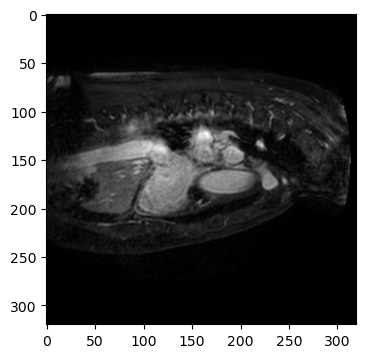

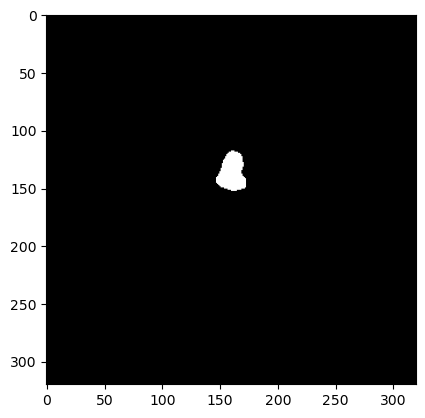

In [12]:
data = cardio('gdrive/MyDrive/data/Train', transform=None, mood='train')
x, y = data[850]
visulalise([x.squeeze(0), y])


In [8]:
len(data)

NameError: name 'data' is not defined

In [9]:
len([item.sum() for item in data.labels if item.sum() > 0]) / len(data)

NameError: name 'data' is not defined

# New Section

In [6]:
model = smp.Unet(
        encoder_name='efficientnet-b4',
        encoder_depth=5,
        encoder_weights='imagenet',
        decoder_use_batchnorm=True,
        decoder_channels= [512, 256, 128, 64, 32],
        # decoder_attention_type=None,
        in_channels=1)

In [7]:
class Unet(nn.Module):
  def __init__(self, num_classes=1000):
    super().__init__()
    self.encoder = nn.Sequential(
      nn.Conv2d(1, 32, kernel_size=5, stride=1),
      nn.BatchNorm2d(32),
      nn.ReLU(inplace=True),
      nn.Conv2d(32, 64, kernel_size=5, stride=1),
      nn.BatchNorm2d(64),
      nn.ReLU(inplace=True),
      nn.Conv2d(64, 128, kernel_size=2, stride=1),
      nn.BatchNorm2d(128),
      nn.ReLU(inplace=True),
      nn.Conv2d(128, 128, kernel_size=2, stride=1),
      nn.BatchNorm2d(128),
      nn.ReLU(inplace=True)
    )

    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(128, 128, kernel_size=2),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(128, 64, kernel_size=2),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(64, 32, kernel_size=5),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(32, 1, kernel_size=5),
        nn.Sigmoid(), # Check
    )


    # self.adaptive_avg_pool2d = nn.AdaptiveAvgPool2d((6, 6))
    # self.flatten = nn.Flatten(start_dim=1)
    # self.classifier = nn.Sequential(
    #     nn.Linear(224*224*512, 4096),
    #     nn.ReLU(inplace=True),
    #     nn.Linear(4096, 4096),
    #     nn.ReLU(inplace=True),
    #     nn.Linear(4096, num_classes),
    #     nn.ReLU(inplace=True),
    # )

  def forward(self, x):
    y = nn.Sequential(self.encoder, self.decoder)(x)
    # y = self.encoder(x)
    # x = self.adaptive_avg_pool2d(x)
    # x = self.flatten(x)
    # x = self.classifier(x)
    return y

In [8]:

# model = Unet()
# criterion = nn.BCELoss()
# criterion = Dice(average='micro')
def Dice(output, target):
    # Convert the target tensor to an integer data type and set requires_grad=True
    
    # Calculate the Dice coefficient
    intersection = torch.sum(output * target)
    union = torch.sum(output) + torch.sum(target)
    return (2 * intersection) / (union + 1e-6)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [9]:

data = cardio('gdrive/MyDrive/data/Train', transform=None, mood='train')
train_data, val_data = torch.utils.data.random_split(data, lengths=[0.9, 0.1], generator=torch.Generator().manual_seed(42))

In [83]:
train_dl = DataLoader(train_data, batch_size= 32, shuffle=True, num_workers=8)
valid_dl = DataLoader(val_data, batch_size= 32, shuffle=True, num_workers=8) #check , increase


In [11]:
# for data in train_dl:
#   print(data)
#   break

(labels > 0).sum(), outputs.numel()

NameError: name 'labels' is not defined

In [12]:
labels.dtype

NameError: name 'labels' is not defined

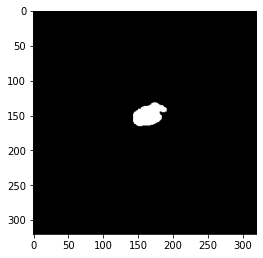

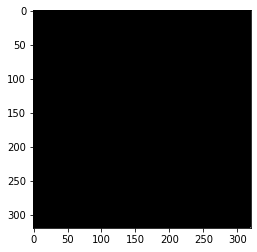

In [ ]:
visulalise((labels[4][0].cpu(), outputs[4][0].cpu().detach().numpy()))

In [13]:
def compute_accuracy(labels, predicted):
  acc = list()
  for label, pred in zip(labels, predicted):
    acc.append((label & pred).sum() / (label | pred).sum())
  return acc

In [14]:
def evaluation(dataloader, mode, epoch):
    model.eval()
    total_loss = 0
    total = 0
    acc_list = list()

    for i, (images, labels) in enumerate(dataloader):
        images = images.to(device).float()
        labels = labels.to(device).float()
        with torch.no_grad():
            outputs = model(images)
            labels = labels.reshape(-1,1,320,320)
            loss = Dice(outputs, labels)
            total_loss += loss.item() * images.size(0)
            total += images.size(0)
            outputs = outputs > 0.5
            labels = labels.type(torch.BoolTensor)
            acc_list.append( jaccard_score(labels.detach().cpu().numpy().reshape(-1), outputs.detach().cpu().numpy().reshape(-1), average='binary'))
            # acc_list += compute_accuracy(labels.to(device), outputs.to(device))
    accuracy = sum(acc_list) / len(acc_list)
    losss = total_loss / total
    print(f'{mode} epoch {epoch} Loss({losss:6.4f}) Accuracy ({accuracy:6.4f})')
    return accuracy


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.is_available()


True

In [17]:
from datetime import datetime

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_gpus = torch.cuda.device_count()
if num_gpus > 1:
    model = torch.nn.DataParallel(model)

model = model.to('cuda')
epochs = 200
for epoch in range(epochs):
  # print(f'epoch: {epoch} {datetime.now()}')
  model.train()
  acc_list = list()
  total = 0
  total_correct = 0
  total_loss = 0
  bs_acc = 0
  for i, (images, labels) in enumerate(train_dl):
    # print(images[123,:].sum())
    images = images.to(device).float()
    labels = labels.to(device).float()

    optimizer.zero_grad()
    outputs = model(images)
    labels = labels.reshape(-1,1,320,320)
    # compute_accuracy 
    loss = Dice(outputs, labels)
    loss.backward()
    optimizer.step()
    total += labels.numel()#images.size(0)
    # outputs[outputs >= 0.5] = 1
    # outputs[outputs < 0.5] = 0
    outputs = outputs > 0.5
    labels = labels.type(torch.BoolTensor)
    acc_list += compute_accuracy(labels.to(device), outputs.to(device))
    # acc_list.append(jaccard_score(labels.reshape(-1), outputs.reshape(-1), average='binary'))
    total_loss += loss.item() * images.size(0) # Check: how to compute accuracy for such problems
  accuracy = sum(acc_list)/ len(acc_list) 
  print(f'Train epoch {epoch}: Loss({total_loss / total:6.8f}) Accuracy ({accuracy:6.8f})')
  val_acc = evaluation(valid_dl,'validation', epoch)
  if (epoch > 30, val_acc > bs_acc):
    torch.save(model, f'smp_{epoch}.pt')
  # evaluate(model, loader, device, criterion, mode='valid')

Train epoch 0: Loss(0.00000877) Accuracy (0.81431311)
validation epoch 0 Loss(0.9058) Accuracy (0.8830)
Train epoch 1: Loss(0.00000877) Accuracy (0.81493336)
validation epoch 1 Loss(0.9060) Accuracy (0.8701)
Train epoch 2: Loss(0.00000877) Accuracy (0.81475252)
validation epoch 2 Loss(0.9056) Accuracy (0.8767)
Train epoch 3: Loss(0.00000878) Accuracy (0.81565064)


KeyboardInterrupt: 

In [21]:
evaluation(valid_dl,'validation', epoch)

validation epoch 3 Loss(0.9047) Accuracy (0.8698)


0.8698218276575111

In [22]:
evaluation(train_dl,'train', epoch)

train epoch 3 Loss(0.9004) Accuracy (0.8720)


0.871983882527656

In [ ]:
torch.save(model.state_dict(), '/content/gdrive/MyDrive/Data/modewl-dict.pt')

In [19]:
model = torch.load('model.pt')

In [ ]:
# def evaluate(model, loader, device, criterion, mode='validation'):
mdl.eval()
total_correct = 0
total_loss = 0
total = 0
acc_list = list()
for i, (images, labels) in enumerate(valid_dl):
  images = images.to(device).float()
  labels = labels.to(device).float()
  with torch.no_grad():
    outputs = mdl(images)
    labels = labels.reshape(-1,1,320,320)
    loss = criterion(outputs, labels)
    total_loss += loss.item() * images.size(0)
    total += images.size(0)
    # _, predictions = outputs.max(1)
    # total_correct += (labels == predictions).sum()
    outputs = outputs > 0.5
    labels = labels.type(torch.BoolTensor)
    acc_list += compute_accuracy(labels.to(device), outputs.to(device))
accuracy = sum(acc_list) / len(acc_list)

losss = total_loss / total
# accuracy = total_correct / total
print(f'Validation Loss({losss:6.4f}) Accuracy ({accuracy:6.4f})')



Validation Loss(0.0025) Accuracy (0.8079)


In [89]:
i = 0

for i, (images,labels) in enumerate(valid_dl):
  if (i == 4):
    print ('f')
    images = images.to(device).float()
    # labels = labels.to(device).float()
    labels = labels.reshape(-1,1,320,320)
    # with torch.no_grad():
    outputs = model(images)
    outputs = outputs > 0.5
    break

f


In [90]:
images.shape, labels.shape

(torch.Size([7, 1, 320, 320]), torch.Size([7, 1, 320, 320]))

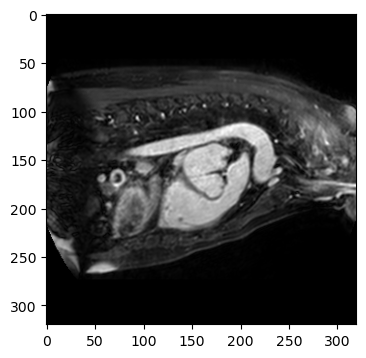

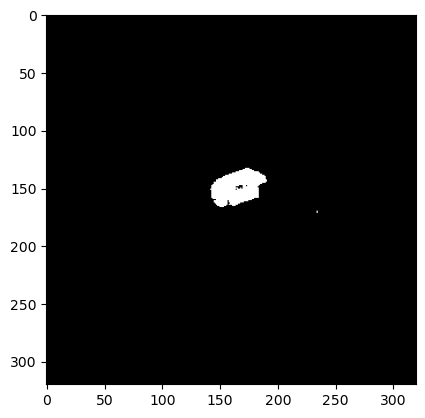

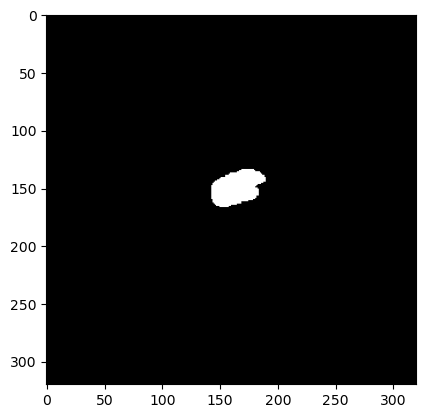

In [94]:
ind = 6
visulalise([images[ind][0].cpu().detach().numpy(),outputs[ind][0].cpu().detach().numpy(),labels[ind][0].cpu().detach().numpy()])

In [48]:
data_test = cardio('', transform=None, mood='test')
test_dl = DataLoader(data_test, batch_size= 32)

In [ ]:
# def evaluate(model, loader, device, criterion, mode='validation'):
mdl.eval()
# total_correct = 0
# total_loss = 0
# total = 0
# acc_list = list()
for i, images in enumerate(test_dl):
  images = images.to(device).float()
  # labels = labels.to(device).float()
  with torch.no_grad():
    outputs = mdl(images)
    # labels = labels.reshape(-1,1,320,320)
    # loss = criterion(outputs, labels)
    # total_loss += loss.item() * images.size(0)
    # total += images.size(0)
    # _, predictions = outputs.max(1)
    # total_correct += (labels == predictions).sum()
    outputs = outputs > 0.5
#     labels = labels.type(torch.BoolTensor)
#     acc_list += compute_accuracy(labels.to(device), outputs.to(device))
# accuracy = sum(acc_list) / len(acc_list)

# losss = total_loss / total
# # accuracy = total_correct / total
# print(f'Validation Loss({losss:6.4f}) Accuracy ({accuracy:6.4f})')



In [ ]:
i = 0
mdl.eval()
while (i < 5 ):
  for i, images in enumerate(test_dl):
    images = images.to(device).float()
    with torch.no_grad():
      outputs = mdl(images)
      outputs = outputs > 0.5

torch.Size([1, 1, 320, 320])

In [ ]:
mdl.eval()
images = torch.tensor(data_test[500]).to(device).float().unsqueeze(0)
with torch.no_grad():
  output = mdl(images)
  output = outputs > 0.5

In [ ]:
images.shape

torch.Size([1, 1, 320, 320])

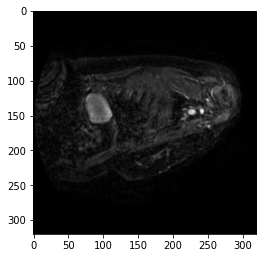

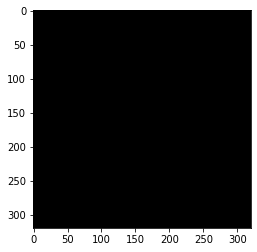

In [ ]:
visulalise([images[0][0].cpu().detach().numpy(),outputs[0][0].cpu().detach().numpy()])

In [ ]:
(outputs > 0.5).cpu().detach().numpy().any()

False